                                        DONCHIAN BREAKOUT-MEAN REVERSION STRATEGY

This approach combines a Mean Reversion Strategy with an added layer of optimization through the integration of the Donchian Breakout Strategy, accompanied by the implementation of stop-loss mechanisms for risk management.

In [17]:
import pandas as pd
import yfinance as yf
import numpy as np
import matplotlib.pyplot as plt
plt.style.use("seaborn")
import ta
import os


For Mean Reversion We Calculate 
1) Moving Averge of 20 days
2) Volatility of 20 days
3) Upper Bolinger Band = MA_20 + 2*(vol_20)
4) lower Bolinger Band = MA_20 - 2*(vol_20)
5) Relative Strength Index using ta library

For Donchian Breakouts We Calculate
1) Calculating the past buydays(default=20) days moving_high
2) Calculating the past selldays(default=40) days moving_low

Below is the Stratrgy function which takes param as
1) stock = ticker symbol
2) start = 1st Jan 2010 (Default)
3) buydays = 20 (default)
4) selldays = 40 (default)
5) invest = 100 (default)
6) stoploss = 0.95(default if stoploss is 5 percent)

This function returns a dataframe 'result' on which we will do our backtesting,
also we can see some graphs


In [18]:
def Strategy(stock,start='2010-01-01',buydays=20,selldays=40,invest=100,stoploss=0.95):
    
    #Collecting_the_stock_data
    df = yf.download(stock,start=start)
    end_date = df.index[-1]
    start_date = pd.to_datetime(start)
    days = (end_date - start_date).days

    #Calculating_Mean_reversion_param 
    df['ma_20'] = df.Close.rolling(20).mean()
    df['vol'] = df.Close.rolling(20).std()
    df['upper_bb'] = df.ma_20 + (2*df.vol)
    df['lower_bb'] = df.ma_20 - (2*df.vol)
    df['rsi'] = ta.momentum.rsi(df.Close, window=6)
    df[['Close','ma_20','upper_bb','lower_bb']].plot(figsize=(12,5),fontsize=12)
    plt.title('Mean Reversion and Bollinger Bands', fontsize=14)
    plt.xlabel('Date', fontsize=12)
    plt.ylabel('Price', fontsize=12)
    plt.show()

    #Calculate_Donchian_Breakout_paran
    period_high=buydays
    df['highest'] = (df.Close.rolling(window=period_high).max()).shift() #past 20days high excluding today
    period_low=selldays
    df['lowest'] = (df.Close.rolling(window=period_low).min()).shift() #past 40 days low excluding today
    df[['Close','highest','lowest']].plot(figsize=(12,5),fontsize=12)
    plt.title('Donchian Channels', fontsize=14)
    plt.xlabel('Date', fontsize=12)
    plt.ylabel('Price', fontsize=12)
    plt.show()

    #Conditions_for_buy_&_sell
    conditions = [
        ((df['rsi'] < 30) & (df['Close'] < df['lower_bb'])) | (df['Close'].shift() > df['highest'].shift()),
        ((df['rsi'] > 70) & (df['Close'] > df['upper_bb'])) | (df['Close'].shift() < df['lowest'].shift())
    ]
    choices = ['Buy', 'Sell']
    df['signal'] = np.select(conditions, choices, default='')
    df.dropna(inplace=True)
    df.signal = df.signal.shift()
    position = False
    buydates, selldates = [],[]
    buyprices, sellprices = [],[]
    #Creating Stoploss
    df['Shifted_close'] = df.Close.shift()

    for index, row in df.iterrows():
        if not position and row['signal'] =='Buy':
            buydates.append(index)
            buyprices.append(row.Open)
            position=True

        if position: 
            if row['signal'] == 'Sell' or row.Shifted_close < 0.9 * buyprices[-1]:
                selldates.append(index)
                sellprices.append(row.Open)
                position=False
    
    if len(buydates) > len(selldates):
        buydates.pop(-1)
    plt.figure(figsize=(18,10))
    plt.plot(df.Close)
    plt.scatter(df.loc[buydates].index,df.loc[buydates].Close,marker='^',c='g')
    plt.scatter(df.loc[selldates].index,df.loc[selldates].Close,marker='v',c='r')   
    plt.title('Buy and Sell Signals', fontsize=14)
    plt.show() 

    #Creating_final_result_dataframe
    result=pd.DataFrame({'buydate':buydates,'selldate':selldates,'buyprice':df.loc[buydates].Close.values,'sellprice':df.loc[selldates].Close.values})
    result['pnl_pct'] = (result.sellprice - result.buyprice)/result.buyprice
    result['cumm_pct'] = (result['pnl_pct'] + 1).cumprod()
    result['returns'] = result.sellprice - result.buyprice 
    result['Equity'] = invest*(result.pnl_pct + 1).cumprod()
    return result,days





[*********************100%%**********************]  1 of 1 completed


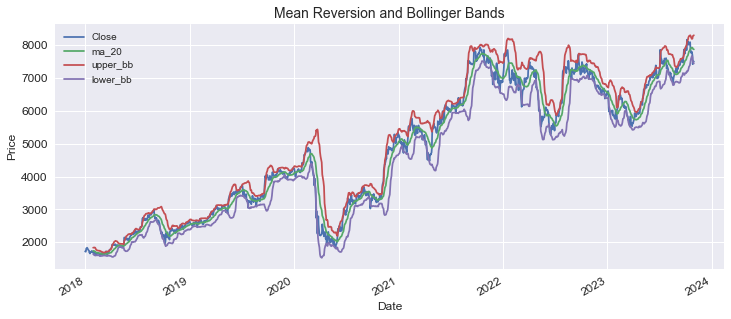

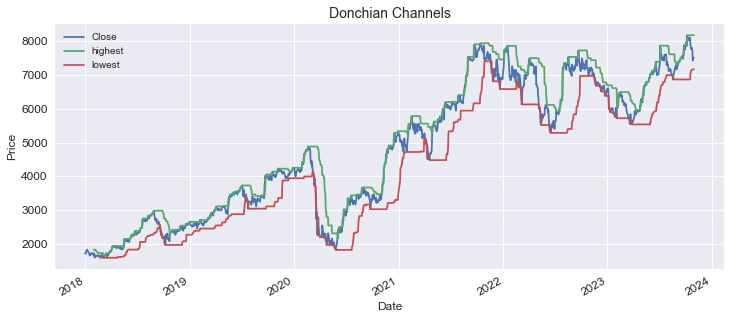

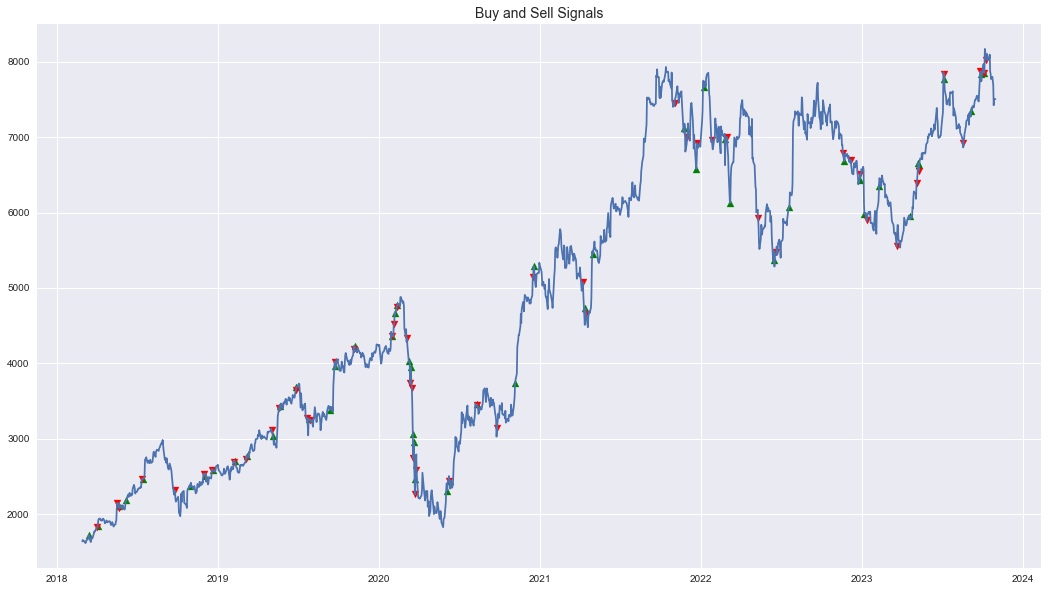

In [19]:
result, days = Strategy(stock='BAJFINANCE.NS', start='2018-01-01',buydays=20,selldays=40)
number_of_years = days/365
number_of_years = int(number_of_years)

Backtesting the Startegy

In [20]:
def Backtesting(result,number_of_days,start='2010-01-01',invest=100):
    #drawdown_calculation
    drawdown = result.Equity
    drawdown = pd.concat([pd.Series([100], index=[drawdown.index[0]]), drawdown])
    max_data = drawdown.rolling(window=len(drawdown),min_periods=1).max()
    dd = drawdown/max_data - 1
    MDD = dd.rolling(window=len(drawdown),min_periods=1).min()
    max_drawdown = MDD.min()*100
    
    #Total_trades
    totaltrades=len(result.pnl_pct)

    #Win_Ratio
    i=0
    profit_trades=len([i for i in result.returns if i>0])
    win_ratio = (profit_trades/totaltrades)*100

    #Net_Strategy_Return
    profit_perc= result.pnl_pct
    list_profits = (profit_perc + 1).cumprod()
    list_profits_df = list_profits.to_frame()
    last_profit = list_profits_df.tail(1).iloc[0, 0]
    net_strategy_return_perc = (last_profit - 1) * 100


    #Loss_making_strategy_acc_percent
    largest_loss_perc_idx = result.pnl_pct.idxmin()
    largest_loss_perc_row = result.loc[largest_loss_perc_idx]

    #profit_making_strategy_acc_percent
    largest_profit_perc_idx = result.pnl_pct.idxmax()
    largest_profit_perc_row = result.loc[largest_profit_perc_idx]

    #Loss_making_strategy_acc_returns
    largest_loss_idx = result.returns.idxmin()
    largest_loss_row = result.loc[largest_loss_idx]

    #profit_making_strategy_acc_returns
    largest_profit_idx = result.returns.idxmax()
    largest_profit_row = result.loc[largest_profit_idx]

    #Final_Return_on_investment
    init_inv=100
    inv_ret=init_inv*(profit_perc + 1).cumprod()
    final_roi=inv_ret[len(inv_ret)-1]
    
    #CAGR/Annualized_total_return
    cagr = (result.iloc[-1].Equity/invest)
    cagr = (np.power(cagr, 1/number_of_years) - 1)*100

    #Benchmark_return_by_cagr_comparison_NIFTY500
    df = yf.download('^CRSLDX', start=start)
    Close = df.Close
    daily_return_nifty = Close.pct_change()
    end_date = df.index[-1]
    start_date = pd.to_datetime(start)
    years = (end_date - start_date).days / 365.0
    years = int(years)
    Equity_nifty = invest*(daily_return_nifty + 1).cumprod()
    cagr_nifty = (Equity_nifty[len(Equity_nifty)-1]/invest)
    cagr_nifty = (np.power(cagr_nifty, 1/years) - 1)*100
    benchmark_return = (cagr - cagr_nifty)

    #Annualized_return
    annualized_ret = result.pnl_pct.mean()*252

    #Average_daily_return
    average_daily_return = result.pnl_pct.sum()
    average_daily_return = average_daily_return/days

    #Annualized_Sharpe_ratio
    volatality=result.pnl_pct.std()*np.sqrt(252)
    risk_free_rate = 0.03
    sharpe_ratio=(annualized_ret-risk_free_rate)/volatality
    


    metrics_df = pd.DataFrame(data={
    'Maximum Drawdown(%)': max_drawdown,
    'Total Trades': totaltrades,
    'Win(%)': win_ratio,
    'Net Startegy Return(%)': net_strategy_return_perc,
    'CAGR(%)': cagr,
    'Annualized Returns(%)': annualized_ret,
    'Benchmark Return (EXCESS CAGR OVER NIFTY500,%)':benchmark_return,
    'Final Return On Investment on invest(default=Rs100)': final_roi,
    'Largest Loss according to percent(%)':largest_loss_perc_row.pnl_pct*100,
    'Largest Loss according to return':largest_loss_row.returns,
    'Largest profit according to percent(%)':largest_profit_perc_row.pnl_pct*100,
    'Largest profit according to return': largest_profit_row.returns,
    'Annualized Sharpe Ratio(risk_free_rate = 3%)':sharpe_ratio,
    'Average Daily Return(%)': average_daily_return

    }, index=[0])
    
    print('')
    print('='*80)
    print('STRATEGY METRICS:')
    print('-'*80)
    print(metrics_df)
    print('-'*80)





    

    


In [21]:
Backtesting(result=result,number_of_days=days)

[*********************100%%**********************]  1 of 1 completed

STRATEGY METRICS:
--------------------------------------------------------------------------------
   Maximum Drawdown(%)  Total Trades  Win(%)  Net Startegy Return(%)  \
0            -46.11619            50    62.0              267.759426   

     CAGR(%)  Annualized Returns(%)  \
0  29.751612               8.335064   

   Benchmark Return (EXCESS CAGR OVER NIFTY500,%)  \
0                                       18.819677   

   Final Return On Investment on invest(default=Rs100)  \
0                                         367.759426     

   Largest Loss according to percent(%)  Largest Loss according to return  \
0                            -23.230801                            -843.0   

   Largest profit according to percent(%)  Largest profit according to return  \
0                                41.35652                         2003.450195   

   Annualized Sharpe Ratio(risk_free_rate = 3%)  Average Daily Re